# **6장. 합성곱 신경망 2**

In [66]:
pip install --user tqdm

# 6.1 이미지 분류를 위한 합성곱 신경망

유형:

**6.1.1 LeNet-5**

합성곱과 다운 샘플링(=풀링)을 반복적으로 거치며, 마지막에 완전연결층에서 분류를 수행하는 것

In [67]:
#1. 필요한 라이브러리 호출

import time
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms #이미지 변환(전처리) 기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim #경사하강법 이용하여 가중치 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os #파일 경로에 대한 함수 제공
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm #진행상황(ex: 모델 학습 경과)을 가시적으로 표현해주는 라이브러리
import random
from matplotlib import pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [68]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [69]:
#2. 이미지 데이터세트 전처리

class ImageTransform() :
  def __init__(self, resize, mean, std) :
    self.data_transform = {
        'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)), #입력이미지를 주어진 크기로 조정(기본 224x224) / 원래 이미지를 무작위 크기(50~100%)만큼 면적 자름
            transforms.RandomHorizontalFlip(), #일정 확률(기본 50%)로 이미지 수평 반전
            transforms.ToTensor(), #효율적인 연산 위해 텐서로 변환
            transforms.Normalize(mean, std) #각 채널별 평균(mean)과 표준편차(std) 정규화
                                      ]),
        'val' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase) : #__call__함수: 클래스 객체 자체를 호출하면 해당 함수의 리턴값 반환
    return self.data_transform[phase](img)

In [70]:
from posixpath import supports_unicode_filenames
#이미지 데이터세트 훈련, 검증, 테스트 세트로 분리

cat_directory = r'/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Cat'
dog_directory = r'/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted( [os.path.join(cat_directory, f) for f in os.listdir(cat_directory)] )
#sorted: 데이터를정렬된 리스트로 만들어서 반환 / os.path.join: 경로와 파일명 결합,또는 분할된 경로 하나로 합칭
# os.listdir: 해당 디렉토리 내 모든 파일 리스트 반환(이미지파일 모두 반환)
dog_images_filepaths = sorted( [os.path.join(dog_directory, f) for f in os.listdir(dog_directory)] )
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths] #개와 고양이 이미지 합쳐서 images_filepaths에 저장
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]

print( len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [71]:
#테스트 데이터셋에 어떤 데이터들이 있는지 확인하는 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5) :
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
  for i, image_filepath in enumerate(images_filepaths) :
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #입력 이미지 / 변환할 이미지 색상 지정(BlueGreenRed -> RGB컬러)
    true_label = os.path.normpath(image_filepath).split(os.sep)[-2] #경로명 정규화  /  '/'나 '\'기준 분할   /   뒤에서 2번쨰
    predicted_label = predicted_labels[i] if predicted_labels else true_label
    color = 'green' if true_label == predicted_label else 'red'
    ax.ravel()[i].imshow(image) #개별 이미지 출력
    ax.ravel()[i].set_title(predicted_label, color=color)
    ax.ravel()[i].set_axis_off()
  plt.tight_layout()
  plt.show()

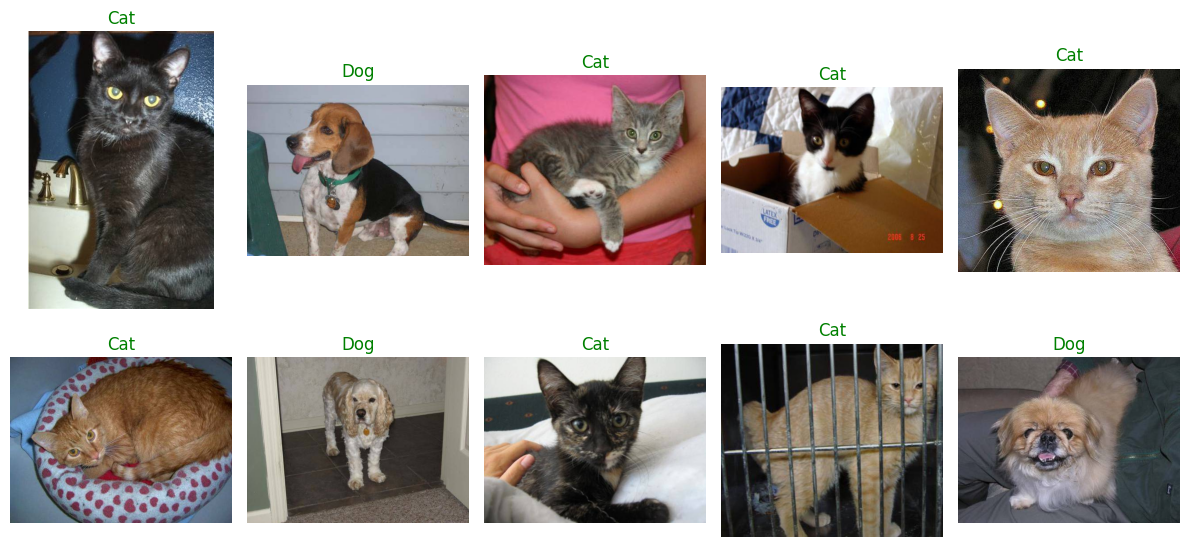

In [72]:
#테스트 데이터세트 이미지 출력
display_image_grid(test_images_filepaths)

In [73]:
#이미지 데이터세트 클래스 정의
class DogVsCatDataset(Dataset) :
  def __init__(self, file_list, transform=None, phase='train') : #데이터셋 전처리하여 적용
    self.file_list = file_list #데이터 경로 저장
    self.transform = transform
    self.phase = phase

  def __len__(self) :
    return len(self.file_list) #images_filepaths 데이터셋 전체 길이 반환

  def __getitem__(self, idx) :
    img_path = self.file_list[idx] #해당 인덱스 이미지의 경로
    img = Image.open(img_path) #경로에서 이미지 데이터 가져옴
    img_transformed = self.transform(img, self.phase) #이미지 'train' 전처리

    label = img_path.split('/')[-1].split('.')[0] #이미지 데이터 경로에 있는 레이블('dog', 'cat') 가져옴
    if label == 'dog' :
      label = 1
    elif label == 'cat' :
      label = 0
    return img_transformed, label

In [74]:
#전처리에 사용할 변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [75]:
#훈련세트, 검증세트 정의

train_dataset = DogVsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogVsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
#torch.Size([3, 244, 244]) >> 이미지가 '컬러' 상태에서 224x224 크기를 가짐
print(train_dataset.__getitem__(index)[1])
#0 또는 1 >> 고양이 또는 개

torch.Size([3, 224, 224])
0


In [76]:
#데이터 로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #데이터를 배치 단위로 쪼개어, 랜덤으로 불러옴
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = { 'train':train_dataloader, 'val':val_dataloader }

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0])


In [77]:
#모델의 네트워크 설계 클래스
class LeNet(nn.Module) :
  def __init__(self) :
    super(LeNet, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #2D 합성곱층. 입력형태 (3,224,224)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(32*53*53, 512)
    self.relu5 = nn.ReLU()
    self.fc2 = nn.Linear(512, 2)
    self.output = nn.Softmax(dim=1)

  def forward(self, x) :
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)

    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)

    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.output(out)

    return out

In [78]:
#복붙

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [79]:
#모델 객체 생성
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [80]:
pip install torchsummary

In [81]:
from torchsummary import summary #출력 결과를 더 한 눈에 들어오게 볼 수 있는 라이브러리
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [82]:
#모델의 학습 가능한 파라미터 수 확인
def count_parameters(model) :
  return sum( p.numel() for p in model.parameters() if p.requires_grad )

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [83]:
#옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#모델의 파라미터, 손실함수 ->cpu
model = model.to(device)
criterion = criterion.to(device)

In [84]:
#모델 학습시키는 함수 정의

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [85]:
#모델 학습

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-84-d17e2cc30f8c>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6983 Acc: 0.4700


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6966 Acc: 0.4674
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6879 Acc: 0.5525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7009 Acc: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6847 Acc: 0.5675


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7128 Acc: 0.5000
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6760 Acc: 0.5850


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7098 Acc: 0.5000
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6735 Acc: 0.5875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6997 Acc: 0.5761
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6694 Acc: 0.5850


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7086 Acc: 0.5109
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6642 Acc: 0.6100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7016 Acc: 0.5652
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6703 Acc: 0.5725


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6946 Acc: 0.5326
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6546 Acc: 0.6300


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6800 Acc: 0.6087
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6479 Acc: 0.6325


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6815 Acc: 0.6304
Training complete in 6m 13s
Best val Acc: 0.630435


In [87]:
#모델 테스트를 위한 함수 정의
import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad() : #역전파 중 가중치 업데이트 필요 없음을 나타냄(학습단계와의 가장 큰 차이)
  for test_path in tqdm(test_images_filepaths) :
    img = Image.open(test_path)
    _id = test_path.split('/')[-1].split('.')[1]
    transform = ImageTransform(size, mean, std)
    img = transform(img, phase='val') #테스트셋 전처리 적용
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()
    outputs = model(img)
    preds = F.softmax(outputs, dim=1)[:, 1].tolist()
    id_list.append(_id)
    pred_list.append(preds[0])

  res = pd.DataFrame({
      'id' : id_list,
      'label' : pred_list
  }) #테스트세트의 예측 결과인 id와 label을 데이터프레임에 저장

  res.sort_values(by='id', inplace=True)
  res.reset_index(drop=True, inplace=True)

  res.to_csv('/content/drive/MyDrive/pytorch_ex/chap06/data/LeNet', index=False)

<ipython-input-87-eb88c2e57114>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths) :


  0%|          | 0/10 [00:00<?, ?it/s]

In [89]:
#테스트 세트 예측 결과 호출
res.head(10) #예측결과가 0.5 이상->개, 0.5 미만->고양이

,id,label
0,109,0.424045
1,145,0.354168
2,15,0.477045
3,162,0.386938
4,167,0.493536
5,200,0.310697
6,210,0.544058
7,211,0.530729
8,213,0.420208
9,224,0.558459


In [94]:
#예측결과 시각적으로 표현 위한 함수
class_ = classes = {0:'cat', 1:'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5) :
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6))
  for i, image_filepath in enumerate(images_filepaths) :
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    a = random.choice(res['id'].values) #데이터 프레임에 있는 id라는 칼럼에서 임의의 데이터값 가져옴
    label = res.loc[ res['id'] == a, 'label' ].values[0]
    if label > 0.5 :
      label = 1
    else :
      label = 0
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(class_[label])
    ax.ravel()[i].set_axis_off()
  plt.tight_layout()
  plt.show()

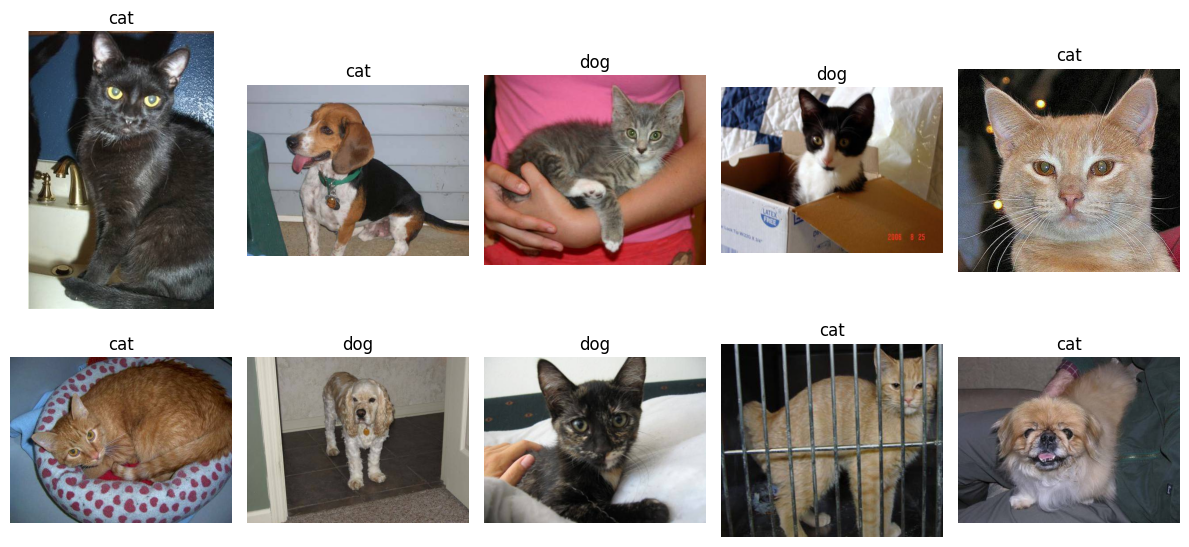

In [95]:
display_image_grid(test_images_filepaths)

**6.1.2 AlexNet**

- 합성곱층 5개, 완전연결층 3개로 구성
- 마지막 완전연결층은 카테고리 1000개 분류를 위한 소프트맥스 함수 사용
- GPU 2개를 기반한 병렬 구조
    - GPU-1 : 컬러와 상관없는 정보를 추출하기 위한 커널이 학습됨
    - GPU-2 : 컬러와 관련있는 정보를 추출하기 위한 커널이 학습됨

In [97]:
#필요한 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [105]:
#데이터 전처리

class ImageTransform() :
  def __init__(self, resize, mean, std) :
    self.data_transform = {
        'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase) :
    return self.data_transform[phase](img)

In [128]:
#훈련 검증 테스트 세트 분리
cat_directory = '/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Cat'
dog_directory = '/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted( [os.path.join(cat_directory, f) for f in os.listdir(cat_directory)] )
dog_images_filepaths = sorted( [os.path.join(dog_directory, f) for f in os.listdir(dog_directory)] )
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[410:]
test_images_filepaths = correct_images_filepaths[400:410]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [107]:
#커스텀 데이터 세트 정의

class DogvsCatDataset(Dataset) :
  def __init__(self, file_list, transform=None, phase='train') :
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self) :
    return len(self.file_list)

  def __getitem__(self, idx) :
    img_path = self.file_list[idx]
    img = Image.open(img_path)
    img_transformed = self.transform(img, self.phase)

    label = img_path.split('/')[-1].split('.')[0]
    if label == 'dog' :
      label = 1
    elif label == 'cat' :
      label = 0

    return img_transformed, label

In [108]:
#변수 값 정의
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [109]:
#훈련 검증 데이터세트 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [111]:
#데이터셋을 메모리로 불러옴
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train':train_dataloader, 'val':val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1])


In [114]:
#AlexNet 모델 신경망 정의
#합성곱층 5, 완전연결층 3

class AlexNet(nn.Module) :

  def __init__(self) -> None :
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)
                    )
    self.avgpool = nn.AdaptiveAvgPool2d( (6,6) ) #(N, C, H_in, W_in) -> (N, C, H_out, W_out) 출력 크기 조정

    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256*6*6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 2)
    )


  def forward(self, x: torch.Tensor) -> torch.Tensor :
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [115]:
#model 객체 생성
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [116]:
#옵티마이저, 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [117]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [118]:
#모델 학습 함수 정의

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [119]:
#모델 학습
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-118-03756e849dbf>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5109
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5109
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5109
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5109
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5109
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6926 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6927 Acc: 0.5109
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6927 Acc: 0.5109
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6927 Acc: 0.5109
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6927 Acc: 0.5109
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6927 Acc: 0.5109
Training complete in 11m 27s


In [121]:
#테스트 세트 예측

import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad() :
  for test_path in tqdm(test_images_filepaths) :
    img = Image.open(test_path)
    _id = test_path.split('/')[-1].split('.')[1]
    transform = ImageTransform(size, mean, std)

    img = transform(img, phase='val')
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()
    outputs = model(img)
    preds = F.softmax(outputs, dim=1)[:, 1].tolist()

    id_list.append(_id)
    pred_list.append(preds[0])

res = pd.DataFrame({
    'id' : id_list,
    'label' : pred_list
})
res.to_csv('/content/drive/MyDrive/pytorch_ex/chap06/data/alexnet.csv', index=False)

<ipython-input-121-e53835b201fa>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths) :


  0%|          | 0/10 [00:00<?, ?it/s]

In [122]:
res.head(10)

,id,label
0,145,0.504237
1,211,0.504640
2,162,0.504441
3,200,0.506109
4,210,0.504783
5,224,0.503847
6,213,0.504069
7,109,0.505165
8,15,0.504394
9,167,0.503996


In [123]:
#예측결과 시각적 표현 함수 정의

class_ = classes = {0:'cat', 1:'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5) :
  rows = len(images_filepaths) // cols

  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
  for i, image_filepath in enumerate(images_filepaths) :
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    a = random.choice(res['id'].values)
    label = res.loc[ res['id'] == a, 'label' ].values[0]
    if label > 0.5 :
      label = 1
    else :
      label = 0

    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(class_[label])
    ax.ravel()[i].set_axis_off

  plt.tight_layout()
  plt.show()

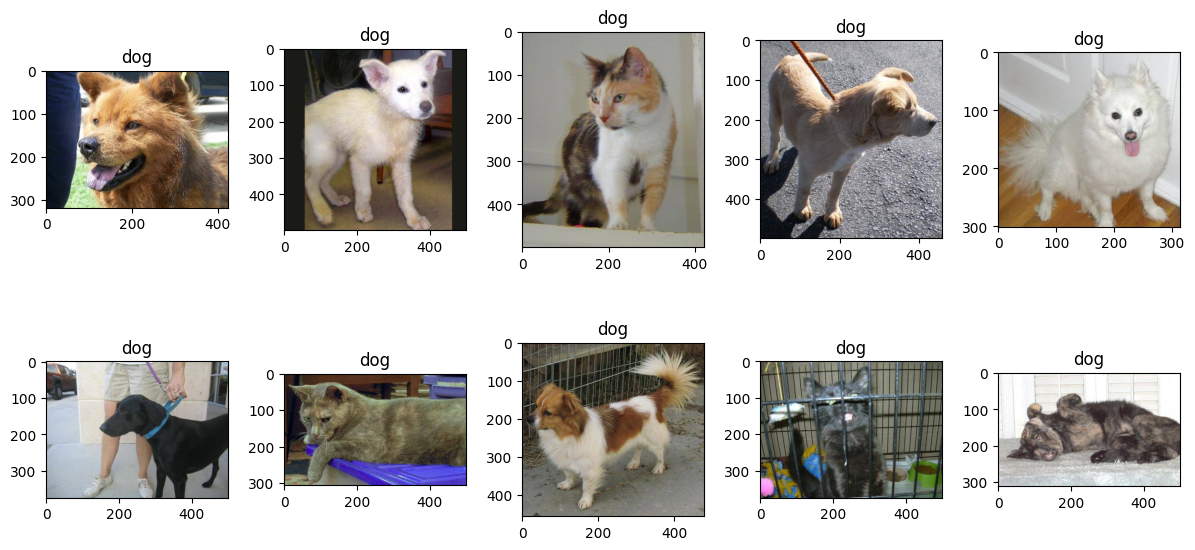

In [129]:
display_image_grid(test_images_filepaths)

**6.1.3 VGGNet**

- 신경망의 깊이의 영향을 확인하고자 만든 신경망
- 모든 합성곱 커널의 크기 : 3x3
- 모든 최대 풀링 커널의 크기 : 2x2
- 모든 스트라이드 : 2

In [130]:
#VGG19 구현
#라이브러리 호출

import copy #객체 복사
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')